In [2]:
### This notebook compared the magic of BD states with those of Haar random states

import qutip as qt
from qutip import *

##Qiskit libraries
import qiskit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import entropy

from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

#scipy
import scipy
import itertools
from scipy.special import psi, polygamma
import math

In [19]:
## Haar random states are generated by sampling coeffs from std. complex gaussian distribution

Paulis = ['I', 'X', 'Y', 'Z']
N = 10
Na = 4
sigma_sum = -8
c = N
str1 = ''
PauliOps=[]

def PauliStrings(N,c,str1):
    if c == 1:
        for k in range(len(Paulis)):
            PauliOps.append(str1 + Paulis[k])
    else:
        for k in range(len(Paulis)):
            PauliStrings(N,c-1,str1+Paulis[k])

PauliStrings(N,c,str1)

def PauliSpectrum(PauliOps, state):
    spec_vals = []
    for op in PauliOps:
        spec_vals.append(state.expectation_value(SparsePauliOp(op)))
    
    return spec_vals

def str_gen(n,s):
    k = int((s + n)/2)

    ##ow we have to generate all strings of length n with val 0's as a list

    ##we can use the itertools library to generate all combinations of n choose val
    if k > n or k < 0:
        raise ValueError("k must be between 0 and n inclusive")

    positions = range(n)
    zero_positions_combinations = itertools.combinations(positions, k)

    bitstrings = []
    for zero_positions in zero_positions_combinations:
        bits = ['1'] * n
        for pos in zero_positions:
            bits[pos] = '0'
        bitstrings.append(''.join(bits))

    return bitstrings

def str_sum(l1,l2):

    #Returns  a list where every element is sum of strings in l1 and l2, all combinations
    #l1 = ['00','01']
    #l2 = ['00','10']
    #returns ['0000','0010','0100','0110']

    l3 = []
    for i in range(len(l1)):
        for j in range(len(l2)):
            l3.append(l1[i] + l2[j])
    return l3

def num_gen(n,s):
    k = int((s + n)/2)

    ##ow we have to generate all strings of length n with val 0's as a list

    ##we can use the itertools library to generate all combinations of n choose val
    if k > n or k < 0:
        raise ValueError("k must be between 0 and n inclusive")

    return math.comb(n,k)

def sample_weighted_dirichlet(dims, num_samples=1):
    """
    Sample from a Dirichlet distribution weighted by sector dimensions.

    Parameters:
    - dims (list or array): List of integers [d_1, d_2, ..., d_J], the dimensions of each sector.
    - num_samples (int): Number of Dirichlet samples to draw.

    Returns:
    - np.ndarray of shape (num_samples, len(dims)): Rows are sampled probability vectors.
    """
    alpha = np.array(dims)
    samples = np.random.dirichlet(alpha, size=num_samples)
    return samples

def HaarState(N):
    coeffs = []
    for i in range(2**N):
        z = np.random.randn() + 1j * np.random.randn()
        coeffs.append(z)
    coeffs = np.array(coeffs)
    hst = Statevector(coeffs)/np.linalg.norm(coeffs)
    return hst


def BDstate(N,Na,sigma_sum):
    dim = 2**N
    na_list = list(range(-Na,Na+1,2))
    nb_list = list(range(-N+Na,N-Na+1,2))

    dja_list = []
    djb_list = []
    index = nb_list.index(sigma_sum - na_list[0])
    i = 0
    while i <= len(na_list)-1 and index >= 0:
        dja_list.append(num_gen(Na,na_list[i]))
        djb_list.append(num_gen(N-Na,nb_list[index]))
        i += 1
        index -= 1
    #print('dja_list',dja_list)
    #print('djb_list',djb_list)

    dj_list = [x*y for x,y in zip(dja_list,djb_list)]
    
    #print('dj_list',dj_list)
    phi_list = []

    if abs(sigma_sum)%2 == N%2 and abs(sigma_sum) <= N:

        index = nb_list.index(sigma_sum - na_list[0])
        i = 0
        while i <= len(na_list)-1 and index >= 0:
            phi = str_sum(str_gen(Na,na_list[i]),str_gen(N-Na,nb_list[index]))
            #print('phi',phi)
            phi_list.append(phi)
            i += 1
            index -= 1
    else:
        print('No valid configurations')
        sys.exit()

    J = len(phi_list)  


    phi_state_list = []
    for i in range(len(phi_list)):
        state_in = Statevector(np.zeros(2**N, dtype=complex))
        for j in range(len(phi_list[i])):
            z = np.random.randn() + 1j * np.random.randn()
            state_in += z*Statevector.from_label(phi_list[i][j])
        state_fin = state_in/np.linalg.norm(state_in)
        phi_state_list.append(state_fin)

    prob_samples = sample_weighted_dirichlet(dj_list, num_samples=1)
    #print('prob_samples',prob_samples)

    state_fin = Statevector(np.zeros(2**N, dtype=complex))
    for i in range(len(phi_state_list)):
        state_fin += prob_samples[0][i]*phi_state_list[i]
    
    return state_fin/np.linalg.norm(state_fin)



In [20]:
##Let us now check the magic distribution of BD states and compare it with Haar random states

num_samples = 100
bd_counts = 0
haar_counts = 0
num_bins = 100
a = -0.2
b = 0.2

for i in range(num_samples):
    print('Sample:',i+1)
    bd_state = BDstate(N,Na,sigma_sum)
    #print('bd_state_check',bd_state.is_valid())
    #haar_state = HaarState(N)
    #print('bd_state_check',bd_state.is_valid())
    
    bd_spec = PauliSpectrum(PauliOps, bd_state)
    #haar_spec = PauliSpectrum(PauliOps, haar_state)

    bd_counts_new,bin_edges = np.histogram(bd_spec, bins=np.linspace(a,b,num_bins+1), density=True)
    #haar_counts_new,bin_edges = np.histogram(haar_spec, bins=np.linspace(a,b,num_bins+1), density=True)
    #print('haar_counts',haar_counts_new)
    bd_counts += bd_counts_new
    #haar_counts += haar_counts_new
bd_counts /= num_samples
#haar_counts /= num_samples
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

np.savetxt(f'bd_counts_N={N},Na={Na},sum={sigma_sum}.txt', bd_counts)
#np.savetxt(f'haar_counts_N={N}.txt', haar_counts)

"""plt.scatter(bin_midpoints, bd_counts, label='BD states', color='blue', alpha=0.5)
plt.scatter(bin_midpoints, haar_counts, label='Haar random states', color='red', alpha=0.5)
plt.xlabel('Pauli Spectrum')
plt.ylabel('Density')"""


Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20
Sample: 21
Sample: 22
Sample: 23
Sample: 24
Sample: 25
Sample: 26
Sample: 27
Sample: 28
Sample: 29
Sample: 30
Sample: 31
Sample: 32
Sample: 33
Sample: 34
Sample: 35
Sample: 36
Sample: 37
Sample: 38
Sample: 39
Sample: 40
Sample: 41
Sample: 42
Sample: 43
Sample: 44
Sample: 45
Sample: 46
Sample: 47
Sample: 48
Sample: 49
Sample: 50
Sample: 51
Sample: 52
Sample: 53
Sample: 54
Sample: 55
Sample: 56
Sample: 57
Sample: 58
Sample: 59
Sample: 60
Sample: 61
Sample: 62
Sample: 63
Sample: 64
Sample: 65
Sample: 66
Sample: 67
Sample: 68
Sample: 69
Sample: 70
Sample: 71
Sample: 72
Sample: 73
Sample: 74
Sample: 75
Sample: 76
Sample: 77
Sample: 78
Sample: 79
Sample: 80
Sample: 81
Sample: 82
Sample: 83
Sample: 84
Sample: 85
Sample: 86
Sample: 87
Sample: 88
Sample: 89
Sample: 90
Sample: 91
Sample: 

"plt.scatter(bin_midpoints, bd_counts, label='BD states', color='blue', alpha=0.5)\nplt.scatter(bin_midpoints, haar_counts, label='Haar random states', color='red', alpha=0.5)\nplt.xlabel('Pauli Spectrum')\nplt.ylabel('Density')"

100
bd_counts_new1 100


Text(0, 0.5, 'Density')

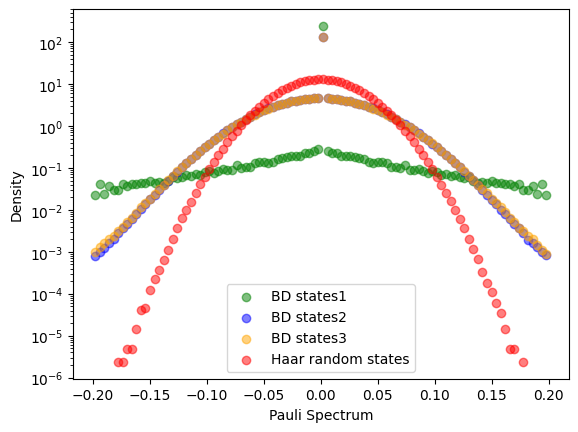

In [21]:
##Let us plot the scatter plots, without the value at x = 0. Remove the bin_midpoints at x = 0

bd_counts_new1 = np.loadtxt(f'bd_counts_N={N},Na={Na},sum={sigma_sum}.txt')
bd_counts_new2 = np.loadtxt(f'bd_counts_N={N},Na=5,sum=0.txt')
bd_counts_new3 = np.loadtxt(f'bd_counts_N={N},Na=4,sum=-2.txt')
haar_counts_new = np.loadtxt(f'haar_counts_N={N}.txt')

bins = np.linspace(a,b,101)
bin_midpoints = (bins[:-1] + bins[1:]) / 2

print(len(bin_midpoints))

print('bd_counts_new1',len(bd_counts_new1))


#plot histogram on log scale
plt.yscale('log')
plt.scatter(bin_midpoints, bd_counts_new1, label='BD states1', color='green', alpha=0.5)
plt.scatter(bin_midpoints, bd_counts_new2, label='BD states2', color='blue', alpha=0.5)
plt.scatter(bin_midpoints, bd_counts_new3, label='BD states3', color='orange', alpha=0.5)
plt.scatter(bin_midpoints, haar_counts_new, label='Haar random states', color='red', alpha=0.5)
plt.legend()
plt.xlabel('Pauli Spectrum')
plt.ylabel('Density')